In [6]:
from collections import defaultdict
import json
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
import os
from scipy import stats
from sklearn import metrics
import pickle

In [7]:
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return h

# init metadata

In [8]:
colors = {
    "L3E1_f1": "tab:blue",
    "L3E1_f2": "tab:olive",
    "L3E4_f1": "tab:cyan",
    "L3E4_f2": "tab:pink",
    "L3": "tab:orange",
    "CN": "tab:green",
    "CRA": "tab:red",
    "CH2": "tab:brown",
    "Sim": "tab:purple",
    "rand": "tab:grey"
}

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "random"]+["L3E1_{}".format(i) for i in ['f1', 'f2']]
methods_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand"]+["L3E1_{}".format(i) for i in ['f1', 'f2']]
abbrev_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand"]+["L3E\n($f_{"+str(i)+"}$)" for i in range(1,3)]
label_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand"]+["L3E($f_{"+str(i)+"}$)" for i in range(1,3)]

methods_names = dict(zip(methods, methods_map))
abbrevs = dict(zip(methods_map, abbrev_map))
labels = dict(zip(methods_map, label_map))

# parse predicted PPIs & GOSemSim scores

In [54]:
# parse ppi of different predictor & ds into one data structure
methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "random"]
ds_names = ['bioGRID', 'STRING', 'MINT']

topPPIs = {}
for randSz in range(50, 100, 10):
    topPPIs[randSz] = defaultdict(dict)
    for method in methods:
        for ds in ds_names:
            if randSz == 50:
                filename = "./linkPred_out_reduced/{}_{}_topPPI.json".format(method, ds)
            else:
                filename = "./linkPred_out_reduced/{}_{}_randSz{}_topPPI.json".format(method, ds, randSz)
            with open(filename, "r") as f:
                tmpPPIs = json.loads(f.read())
                topPPIs[randSz][method][ds] = []
                for trial in range(len(tmpPPIs)):
                    topPPIs[randSz][method][ds].append(["\t".join(i) for i in tmpPPIs[trial]])
            
# structure: topPPIs = {'commonNeighbor': ['bioGRID': [[ppi1, ppi2], ...], ...], ...}
print(topPPIs[50]['commonNeighbor']['bioGRID'][0][0:10])

['DHH1\tCCR4', 'DHH1\tNAB2', 'DHH1\tMPT5', 'DHH1\tSSB2', 'DHH1\tPUF3', 'MPT5\tCCR4', 'PUF3\tCCR4', 'ISW1\tCCR4', 'DHH1\tISW1', 'SSB2\tNAB2']


In [ ]:
GO_PPIMap, GO_scoreMap = [], []

fNames = set()
for file in os.listdir("./GOSemSim_out"): fNames.add(file.split(" _")[0])
    
for file in fNames:
    if 'human' in file or 'HuRI' in file: continue
    with open("./GOSemSim_out/{} _PPI.json".format(file), "r") as f:
        readPPIs = json.loads(f.read())
        GO_PPIMap += readPPIs
    with open("./GOSemSim_out/{} _GOSemSim.json".format(file), "r") as f:
        readScores = json.loads(f.read())
        GO_scoreMap += readScores
        
GOSemSimMap = {}
for i in range(len(GO_PPIMap)): GOSemSimMap["\t".join(GO_PPIMap[i])] = GO_scoreMap[i]
    
print(list(GOSemSimMap.keys())[0:10])
print(list(GOSemSimMap.values())[0:10])

# Get GOSemSim scores of PPIs into df

In [6]:
# construct df for plotting
df_dict = defaultdict(list)
ds_names = ['bioGRID', 'STRING', 'MINT']

for randSz in range(50, 100, 10):
    for method in methods:
        for ds in ds_names:
            for trial in range(len(topPPIs[randSz][method][ds])):
                for i in range(len(topPPIs[randSz][method][ds][trial])):
                    df_dict['randSz'].append(randSz)
                    df_dict['ds'].append(ds)
                    df_dict['trial'].append(trial)
                    df_dict['rank'].append(i)
                    df_dict["score"].append(GOSemSimMap[topPPIs[randSz][method][ds][trial][i]])
                    df_dict["predictor"].append(methods_names[method])

df = pd.DataFrame(df_dict)
df

,randSz,ds,trial,rank,score,predictor
0,50,bioGRID,0,0,0.158,CN
1,50,bioGRID,0,1,0.644,CN
2,50,bioGRID,0,2,0.567,CN
3,50,bioGRID,0,3,0.429,CN
4,50,bioGRID,0,4,0.641,CN
...,...,...,...,...,...,...
26947915,90,MINT,9,1687,0.252,rand
26947916,90,MINT,9,1688,0.100,rand
26947917,90,MINT,9,1689,0.203,rand
26947918,90,MINT,9,1690,0.060,rand


# Get data for plotting

In [7]:
# get top 10% score group by method & ds, avg across trial, ignore NaN

#topTenPPIs = df[df['rank'] < int(np.max(df['rank'])*0.1)].copy()

topTenPPIs = df.copy()
topTenPPIs.drop(columns=['rank'], inplace=True)
topTenPPIs

,randSz,ds,trial,score,predictor
0,50,bioGRID,0,0.158,CN
1,50,bioGRID,0,0.644,CN
2,50,bioGRID,0,0.567,CN
3,50,bioGRID,0,0.429,CN
4,50,bioGRID,0,0.641,CN
...,...,...,...,...,...
26947915,90,MINT,9,0.252,rand
26947916,90,MINT,9,0.100,rand
26947917,90,MINT,9,0.203,rand
26947918,90,MINT,9,0.060,rand


In [10]:
# create dict of sorted mean GOSemSim scores & conf interval
meanScore_dict, std_dict, score_dict = {}, {}, {}
for randSz in range(50, 100, 10):
    meanScore_dict[randSz], std_dict[randSz], score_dict[randSz] = defaultdict(dict), defaultdict(dict), defaultdict(dict)
    for ds in set(topTenPPIs['ds']):
        # get mean GOSemSim & conf Int for each predictor
        for predictor in set(topTenPPIs[(topTenPPIs['ds'] == ds) & (topTenPPIs['randSz'] == randSz)]['predictor']):
            tmpMean = []
            for trial in range(10):
                curScores = np.asarray(topTenPPIs[(topTenPPIs['randSz'] == randSz) & (topTenPPIs['ds'] == ds) & (topTenPPIs['predictor'] == predictor) & (topTenPPIs['trial'] == trial)]['score'])
                curScores = curScores[~np.isnan(curScores)]
                tmpMean.append(np.mean(curScores))
            score_dict[randSz][ds][predictor] = tmpMean
            meanScore_dict[randSz][ds][predictor] = np.mean(tmpMean)
            std_dict[randSz][ds][predictor] = np.std(tmpMean)
        meanScore_dict[randSz][ds] = dict(sorted(meanScore_dict[randSz][ds].items(), key=lambda item: item[1])[::-1])

        tmp = {}
        for predictor in meanScore_dict[randSz][ds]: tmp[predictor] = std_dict[randSz][ds][predictor]
        std_dict[randSz][ds] = tmp
    
with open("./GOSemSim_out/score_dict.pkl", "wb") as f:
    pickle.dump(score_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("./GOSemSim_out/meanScore_dict.pkl", "wb") as f:
    pickle.dump(meanScore_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("./GOSemSim_out/std_dict.pkl", "wb") as f:
    pickle.dump(std_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
    
print(meanScore_dict)
print("")
print(std_dict)

{50: defaultdict(<class 'dict'>, {'MINT': {'L3E1_f1': 0.3940309211627616, 'L3E1_f2': 0.3896972158320652, 'CH2': 0.37732208278206325, 'L3': 0.37535242873070335, 'CN': 0.37011901640550526, 'Sim': 0.3652444996286086, 'CRA': 0.26331303482227886, 'rand': 0.2598856121022108}, 'bioGRID': {'CRA': 0.36283736808210737, 'CN': 0.3581096223672454, 'L3E1_f1': 0.30571319301253075, 'L3E1_f2': 0.30324070777222484, 'L3': 0.29270235915825354, 'CH2': 0.29056165881608675, 'rand': 0.2574337942999446, 'Sim': 0.25511304099205023}, 'STRING': {'CRA': 0.48121832684217003, 'L3E1_f1': 0.4789385192543336, 'CN': 0.4781333043543018, 'L3E1_f2': 0.47544982362243127, 'L3': 0.46847167978421433, 'Sim': 0.46785415085073867, 'CH2': 0.45947497391119124, 'rand': 0.24327012863040803}}), 60: defaultdict(<class 'dict'>, {'MINT': {'L3E1_f2': 0.4229714581350815, 'L3E1_f1': 0.4084875178357582, 'CH2': 0.39919089013283177, 'L3': 0.38427742755836247, 'CN': 0.3812822755380093, 'CRA': 0.3805571071550447, 'Sim': 0.37738046998101693, 'ran

In [9]:
meanScore_dict, std_dict, score_dict = {}, {}, {}
with open("./GOSemSim_out/score_dict.pkl", "rb") as f:
    score_dict = pickle.load(f)
with open("./GOSemSim_out/meanScore_dict.pkl", "rb") as f:
    meanScore_dict = pickle.load(f)
with open("./GOSemSim_out/std_dict.pkl", "rb") as f:
    std_dict = pickle.load(f)

# Create figure

In [10]:
# AUC of scatter plot
auc_map = {}

dss = ['bioGRID', 'STRING', 'MINT']
for ds in dss:
    auc_map[ds] = defaultdict(list)
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
        for trial in range(10):
            X = [randSz/100 for randSz in range(50, 100, 10)]
            Y = [score_dict[randSz][ds][method][trial] for randSz in range(50, 100, 10)]
            auc_map[ds][method].append(metrics.auc(X, Y))
            
sorted_mean_auc, err_auc = {}, {}
for ds in auc_map:
    sorted_mean_auc[ds], err_auc[ds] = {}, {}
    for method in auc_map[ds]:
        sorted_mean_auc[ds][method] = np.mean(auc_map[ds][method])
        err_auc[ds][method] = np.std(auc_map[ds][method])
    sorted_mean_auc[ds] = dict(sorted(sorted_mean_auc[ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{'bioGRID': {'Sim': 0.09782107766629654, 'rand': 0.10340026564049809, 'L3': 0.11750585278032019, 'CH2': 0.11780448256167153, 'L3E1_f1': 0.12126400977141827, 'L3E1_f2': 0.12206360268792578, 'CN': 0.15269742561882055, 'CRA': 0.15342349559925855}, 'STRING': {'rand': 0.09827546996927397, 'CH2': 0.19091576402346694, 'L3': 0.19392667072083733, 'Sim': 0.19427208735011947, 'L3E1_f2': 0.19610313452711564, 'L3E1_f1': 0.1967083049946548, 'CN': 0.19695376757821376, 'CRA': 0.19894525251331205}, 'MINT': {'rand': 0.10324567236584001, 'Sim': 0.1539957273702494, 'L3': 0.15442113325707124, 'CN': 0.15724646582052, 'CRA': 0.16006419617930942, 'CH2': 0.1616993836431097, 'L3E1_f1': 0.16842611654925066, 'L3E1_f2': 0.17341030047048184}}


# gridspec

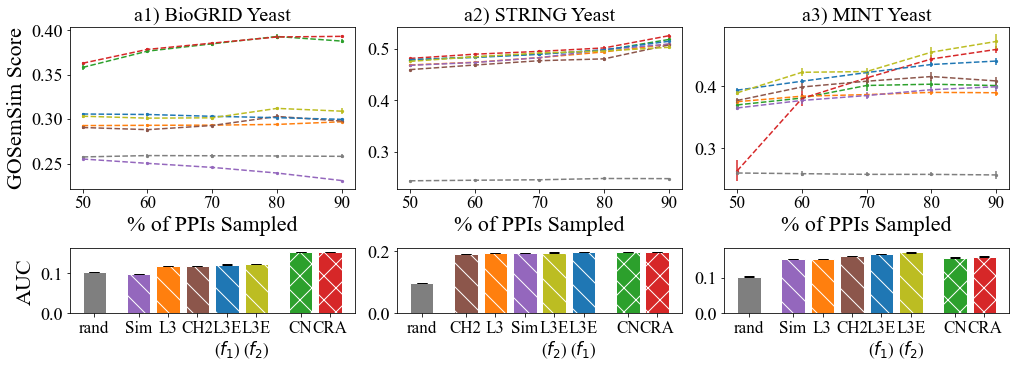

In [9]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

fig = plt.figure(constrained_layout=True, figsize=(14, 5))
widths = [1,1,1]
heights = [5,2]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]


# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
        ax.errorbar([randSz for randSz in range(50, 100, 10)]
                    , [meanScore_dict[randSz][ds][method] for randSz in range(50, 100, 10)]
                    , fmt='--', color=colors[method]
                    , yerr=np.transpose(np.asarray(
                        [std_dict[randSz][ds][method] for randSz in range(50, 100, 10)]
                    )))
        ax.scatter([randSz for randSz in range(50, 100, 10)]
                    , [meanScore_dict[randSz][ds][method] for randSz in range(50, 100, 10)]
                   , s=5, color=colors[method])
        ax.set_xlabel("% of PPIs Sampled")
    #ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    ax.set_xticks([randSz for randSz in range(50, 100, 10)])
    ax.set_title("a{}) {} Yeast".format(i+1, dsNames[i]))

    
lineAxes[0].set_ylabel("GOSemSim Score")


# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]
    pos = [0,1.5,2.5,3.5,4.5,5.5,7,8]
    xtick = [k for k in list(sorted_mean_auc[ds].keys()) if k not in ['rand', 'CRA', 'CN']]
    xtick = ['rand'] + xtick + [k for k in list(sorted_mean_auc[ds].keys()) if k in ['CRA', 'CN']]
    ax.bar(pos, [sorted_mean_auc[ds][x] for x in xtick]
                      , yerr=[err_auc[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                       , tick_label=[abbrevs[x] for x in xtick]
                      , edgecolor='white', capsize=5)
    for i, patch in enumerate(ax.patches): patch.set_hatch(hatches[i])
barAxes[0].set_ylabel("AUC")

plt.savefig("./img_experiments/GOSemSimComplete_wRand.png", dpi=300)
plt.show()

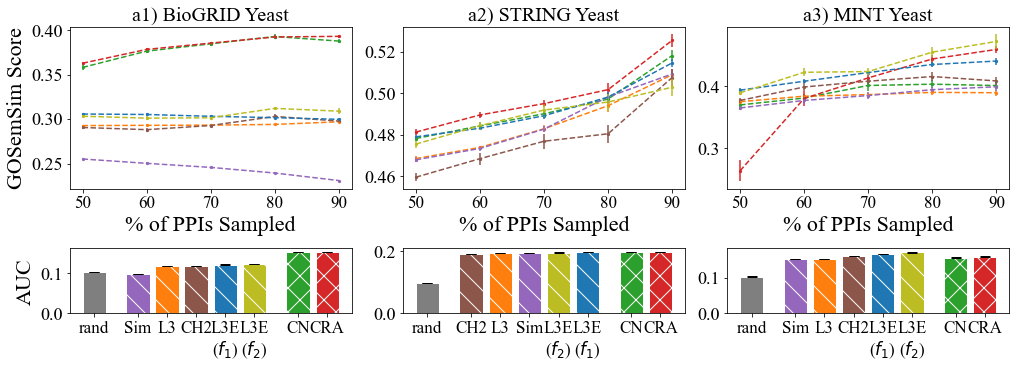

In [75]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

fig = plt.figure(constrained_layout=True, figsize=(14, 5))
widths = [1,1,1]
heights = [5,2]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, col]) for col in range(3)]
barAxes = [fig.add_subplot(spec[1, col]) for col in range(3)]


# lineAxes
dss = ['bioGRID', 'STRING', 'MINT']
dsNames = ['BioGRID', 'STRING', 'MINT']
for i in range(len(dss)):
    ds = dss[i]
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        ax.errorbar([randSz for randSz in range(50, 100, 10)]
                    , [meanScore_dict[randSz][ds][method] for randSz in range(50, 100, 10)]
                    , fmt='--', color=colors[method]
                    , yerr=np.transpose(np.asarray(
                        [std_dict[randSz][ds][method] for randSz in range(50, 100, 10)]
                    )))
        ax.scatter([randSz for randSz in range(50, 100, 10)]
                    , [meanScore_dict[randSz][ds][method] for randSz in range(50, 100, 10)]
                   , s=5, color=colors[method])
        ax.set_xlabel("% of PPIs Sampled")
    #ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    ax.set_xticks([randSz for randSz in range(50, 100, 10)])
    ax.set_title("a{}) {} Yeast".format(i+1, dsNames[i]))

    
lineAxes[0].set_ylabel("GOSemSim Score")


# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]
    pos = [0,1.5,2.5,3.5,4.5,5.5,7,8]
    xtick = [k for k in list(sorted_mean_auc[ds].keys()) if k not in ['rand', 'CRA', 'CN']]
    xtick = ['rand'] + xtick + [k for k in list(sorted_mean_auc[ds].keys()) if k in ['CRA', 'CN']]
    ax.bar(pos, [sorted_mean_auc[ds][x] for x in xtick]
                      , yerr=[err_auc[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                       , tick_label=[abbrevs[x] for x in xtick]
                      , edgecolor='white', capsize=5)
    for i, patch in enumerate(ax.patches): patch.set_hatch(hatches[i])
barAxes[0].set_ylabel("AUC")

plt.savefig("./img_experiments/GOSemSimComplete.png", dpi=300)
plt.show()

# p-val

In [103]:
# p val
# sample to do: top 2 both to third, between top 2
dss = ['bioGRID', 'STRING', 'MINT']
pairs = [
    [['L3E4_f1', 'CRA'], ['L3E4_f1', 'CH2']]
    , [['L3E4_f1', 'CRA'], ['L3E4_f1', 'Sim']]
    , [['L3E4_f1', 'CRA'], ['L3E4_f1', 'Sim']]
]
for i in range(len(dss)):
    ds = dss[i]
    for pair in pairs[i]:
        pop1 = score_dict[ds][pair[0]]
        pop2 = score_dict[ds][pair[1]]
        pVal = stats.ttest_ind(pop1, pop2)[1]
        print("{}: {} {}: {}".format(ds, pair[0], pair[1], pVal))

bioGRID: L3E4_f1 CRA: 4.495345767372192e-24
bioGRID: L3E4_f1 CH2: 2.449531995248696e-08
STRING: L3E4_f1 CRA: 2.0736906492095788e-09
STRING: L3E4_f1 Sim: 2.2675021968443377e-08
MINT: L3E4_f1 CRA: 0.0006539623087037534
MINT: L3E4_f1 Sim: 0.6101532760087356
